<a href="https://colab.research.google.com/github/animesh-am/CodeClause_Internship/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

In [14]:
!apt install python3-pyaudio
!pip install pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-pyaudio is already the newest version (0.2.11-1.3ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


## Import Necessary Libraries

In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import os
import glob
import IPython.display as ipd
import soundfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

## Download Dataset from Kaggle

In [16]:
# Ensure kaggle.json is uploaded
if not os.path.exists('kaggle.json'):
    raise ValueError("kaggle.json is not uploaded. Please upload the Kaggle API key to proceed.")

# Setting up kaggle and downloading the dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
if not os.path.exists("/content/audio"):
    !kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
    !unzip ravdess-emotional-speech-audio -d ./audio
    !rm ravdess-emotional-speech-audio.zip


mkdir: cannot create directory ‘/root/.kaggle’: File exists


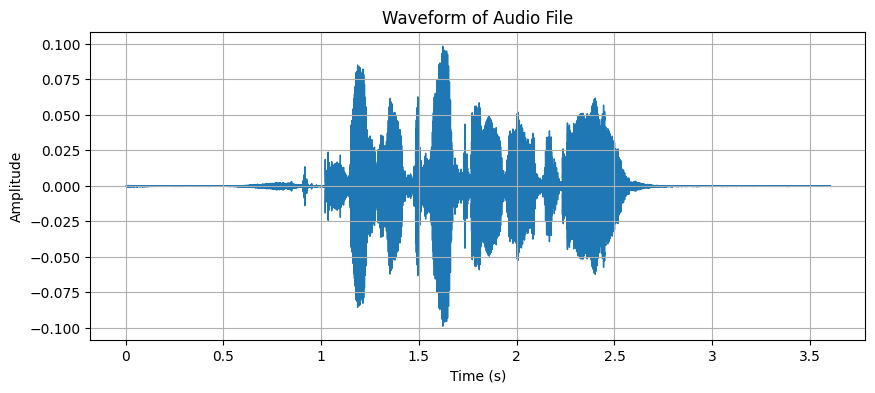

In [34]:
import IPython.display as ipd
import librosa.display

# Define the path of the audio file
file_path = '/content/audio/Actor_10/03-01-02-01-01-02-10.wav'

# Load the audio file
y, sr = librosa.load(file_path, sr=None)

# Plotting the audio waveform
plt.figure(figsize=(10, 4))

# Displaying the waveform
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Play the audio
ipd.Audio(file_path)




In [17]:
# Get the list of all .wav files under Actor_* subdirectories
files = glob.glob("./audio/Actor_*/*.wav")
print(f"Total number of .wav files found: {len(files)}")

# Create a dictionary to store counts per subfolder
file_counts = {}

# Loop through each file
for file in files:
    # Get the subfolder name
    subfolder = os.path.dirname(file)

    # If the subfolder is not in the dictionary, add it with count 1
    # Else, increment the count
    if subfolder not in file_counts:
        file_counts[subfolder] = 1
    else:
        file_counts[subfolder] += 1

# Print the counts for each subfolder
for subfolder, count in file_counts.items():
    print(f"{subfolder}: {count} .wav files")

Total number of .wav files found: 1440
./audio/Actor_10: 60 .wav files
./audio/Actor_11: 60 .wav files
./audio/Actor_04: 60 .wav files
./audio/Actor_18: 60 .wav files
./audio/Actor_21: 60 .wav files
./audio/Actor_22: 60 .wav files
./audio/Actor_14: 60 .wav files
./audio/Actor_08: 60 .wav files
./audio/Actor_17: 60 .wav files
./audio/Actor_13: 60 .wav files
./audio/Actor_05: 60 .wav files
./audio/Actor_07: 60 .wav files
./audio/Actor_16: 60 .wav files
./audio/Actor_02: 60 .wav files
./audio/Actor_12: 60 .wav files
./audio/Actor_03: 60 .wav files
./audio/Actor_09: 60 .wav files
./audio/Actor_15: 60 .wav files
./audio/Actor_20: 60 .wav files
./audio/Actor_19: 60 .wav files
./audio/Actor_23: 60 .wav files
./audio/Actor_01: 60 .wav files
./audio/Actor_24: 60 .wav files
./audio/Actor_06: 60 .wav files


In [18]:
# Load an audio file
file_path = '/content/audio/Actor_10/03-01-02-01-01-02-10.wav'
y, sr = librosa.load(file_path, sr=None)  # y is the time series, sr is the sampling rate

# Play the audio
ipd.Audio(y, rate=sr)

## Define Emotion Categories and Extract Features

In [19]:
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_features(y, sr):
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)
    return np.hstack((chroma, mel, contrast, tonnetz))


## Data Augmentation

In [20]:
def noise_injection(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_signal = y + noise_factor * noise
    return np.clip(augmented_signal, -1, 1)

def time_stretch(y, sr, rate=0.8):
    num_samples = int(len(y) * rate)
    y_stretch = scipy.signal.resample(y, num_samples)
    return y_stretch

def pitch_shift(y, sr, n_steps=2.0):
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)


In [21]:
# Paths
base_path = "./audio"
actor_folders = os.listdir(base_path)

data = []
data_files = []
labels = []

# Data collection
for actor in actor_folders:
    actor_path = os.path.join(base_path, actor)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith('.wav'):
                emotion_code = int(file_name.split("-")[2]) - 1
                emotion_string = emotions['0'+str(emotion_code + 1)]
                file_path = os.path.join(actor_path, file_name)
                data_files.append(file_path)
                y, sr = librosa.load(file_path, duration=2.5, offset=0.5)
                mfccs = extract_features(y, sr)
                data.append(mfccs)
                labels.append(emotion_string)


In [22]:
print(np.shape(data))
print(np.shape(labels))
print(len(data_files))

(1440, 153)
(1440,)
1440


## Collect and Process Data

In [23]:
# Add the augmentations to our data loading
# Data augmentation
data_augmented = []
labels_augmented = []
for file_name, emotion in tqdm(zip(data_files, labels), total=len(data_files), desc="Processing"):
    y, sr = librosa.load(file_name, duration=2.5, offset=0.5)

    # Original data
    data_augmented.append(extract_features(y, sr))
    labels_augmented.append(emotion)

    # Noise injection
    data_augmented.append(extract_features(noise_injection(y), sr))
    labels_augmented.append(emotion)

    # Time stretching
    data_augmented.append(extract_features(time_stretch(y, sr), sr))
    labels_augmented.append(emotion)

    # Pitch shifting
    data_augmented.append(extract_features(pitch_shift(y, sr), sr))
    labels_augmented.append(emotion)

Processing:   0%|          | 0/1440 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(
Processing:   6%|▌         | 83/1440 [02:05<32:50,  1.45s/it]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=851
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=681
  warnings.warn(
Processing:  40%|███▉      | 570/1440 [14:24<21:56,  1.51s/it]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=840
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/co

In [24]:
# Let's add this noise data to the original data and labels
combined_data = np.vstack((data, data_augmented))
combined_labels = labels + labels_augmented


In [25]:
print(np.shape(combined_data))
print(np.shape(combined_labels))

(7200, 153)
(7200,)


In [26]:
print(f"Size of combined data: {len(combined_data)}")
print(f"Size of combined labels: {len(combined_labels)}")


Size of combined data: 7200
Size of combined labels: 7200


## Split Data and Create CNN Model

In [27]:
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train_encoded = to_categorical(encoder.fit_transform(y_train))
y_test_encoded = to_categorical(encoder.transform(y_test))
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(2, 1), activation='relu', input_shape=input_shape))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 1)))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv2D(64, kernel_size=(2, 1), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 1)))
model_cnn.add(Dropout(0.1))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(8, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Train the CNN Model

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_cnn.fit(X_train_cnn, y_train_encoded, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stop])

evaluation = model_cnn.evaluate(X_test_cnn, y_test_encoded)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")


Epoch 1/200
144/144 [==============================] - 5s 20ms/step - loss: 2.4584 - accuracy: 0.1808 - val_loss: 2.1962 - val_accuracy: 0.1562
Epoch 2/200
144/144 [==============================] - 2s 17ms/step - loss: 2.1572 - accuracy: 0.2372 - val_loss: 2.2313 - val_accuracy: 0.1571
Epoch 3/200
144/144 [==============================] - 2s 17ms/step - loss: 2.0291 - accuracy: 0.2559 - val_loss: 1.9753 - val_accuracy: 0.1606
Epoch 4/200
144/144 [==============================] - 3s 24ms/step - loss: 1.9345 - accuracy: 0.2849 - val_loss: 1.8313 - val_accuracy: 0.2561
Epoch 5/200
144/144 [==============================] - 2s 17ms/step - loss: 1.8880 - accuracy: 0.3008 - val_loss: 1.6844 - val_accuracy: 0.3646
Epoch 6/200
144/144 [==============================] - 2s 16ms/step - loss: 1.8485 - accuracy: 0.3158 - val_loss: 1.6779 - val_accuracy: 0.3429
Epoch 7/200
144/144 [==============================] - 2s 16ms/step - loss: 1.7796 - accuracy: 0.3320 - val_loss: 1.6668 - val_accuracy:

## Visualization of Training Progress

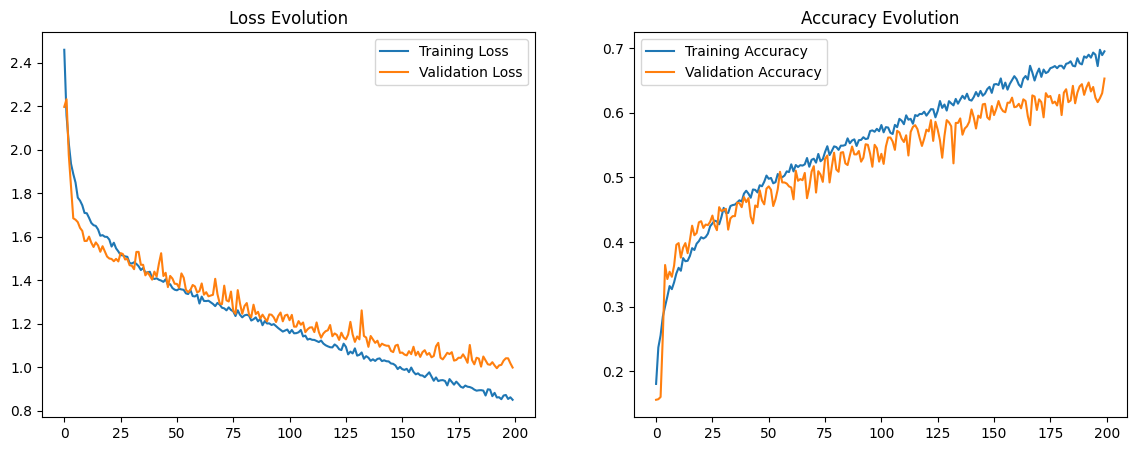

In [29]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()


## Prediction on a Sample

In [31]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

def get_emotion_from_filename(filename):
    # Splitting the filename by '-' and taking the third item
    emotion_code = filename.split("-")[2]
    return emotions[emotion_code]


file_path = "/content/audio/Actor_07/03-01-08-02-02-02-07.wav"
actual_emotion = get_emotion_from_filename(file_path)
y, sr = librosa.load(file_path, duration=2.5, offset=0.5)
features = extract_features(y, sr)
features = np.expand_dims(features, axis=0)
features = features.reshape(1, 153, 1, 1)
predicted_vector = model_cnn.predict(features)
predicted_class = np.argmax(predicted_vector)
predicted_emotion = encoder.inverse_transform([predicted_class])[0]
confidence = predicted_vector[0][predicted_class]
print(f"Actual emotion: {actual_emotion}")
print(f"Predicted emotion: {predicted_emotion} with confidence: {100*confidence:.2f}%")


1/1 [==============================] - 0s 295ms/step
Actual emotion: surprised
Predicted emotion: surprised with confidence: 98.13%
